In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tqdm
import scipy
%matplotlib inline

In [2]:
def d(u, v):
    return np.linalg.norm(u - v, axis=-1)

def triangle_algorithm(S, p, eps = 1e-3, seed = 0):
    # simple implementation, by the book
    S_dist = scipy.spatial.distance_matrix(S, S)
    R = S_dist.max()
    p_dist = d(S, p)
    z = S[np.argmin(p_dist)]
    idx = np.arange(len(S))
    state = np.random.RandomState(seed)
    while True:
        if d(z, p) <= eps * R:
            return (True, z)
        z_dist = d(S, z)
        state.shuffle(idx)
        for i in idx:
            v = S[i]
            if d(z, v) >= p_dist[i]:
                x = v - z
                a = np.dot(p - z, x) / np.dot(x, x)
                z = (1 - a) * z + a * v
                break
        else:
            return (False, z)        

In [20]:
# same as above, but much, much faster

import numba as nb

@nb.njit(nogil=True)
def nb_d2(u, v):
    d = 0.0
    for i in range(len(u)):
        z = u[i] - v[i]
        d += z * z
    return d  # note: squared distance, not the norm

@nb.njit(nogil=True)
def nb_triangle_algorithm(S, p, eps=1e-3, seed=0):
    np.random.seed(seed)
    n, m = S.shape
    R2 = 0.0
    for i in range(n - 1):
        for j in range(i + 1, n):
            R2 = max(R2, nb_d2(S[i], S[j]))
    tol2 = (eps ** 2) * R2
    p_dist = np.zeros(n, p.dtype)
    for i in range(n):
        p_dist[i] = nb_d2(S[i], p)
    z = S[np.argmin(p_dist)]
    idx = np.arange(n)
    while True:
        dist = 0.0
        if nb_d2(z, p) <= tol2:
            return (True, z)
        np.random.shuffle(idx)
        for i in idx:
            v = S[i]
            x = v - z
            u = 0.0
            for k in range(m):
                u += x[k] * x[k]
            if u >= p_dist[i]:
                a = 0.0
                for k in range(m):
                    a += (p[k] - z[k]) * x[k]
                a /= u
                z = (1 - a) * z + a * v
                break
        else:
            return (False, z)
    return (False, p)

In [59]:
%time avta_hull(data, 1e-2, 10)

CPU times: user 209 ms, sys: 3.4 ms, total: 213 ms
Wall time: 213 ms


array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [4]:
def triangle_hull(S, eps = 1e-3, seed = 0, impl = 'fast'):
    func = {'fast': nb_triangle_algorithm, 'slow': triangle_algorithm}[impl]
    out = np.zeros(len(S), bool)
    for i in range(len(S)):
        v = S[i]
        S_v = np.concatenate([S[:i], S[i + 1:]])
        out[i] = not func(S_v, v, eps=eps, seed=seed)[0]
    return out

In [5]:
def avta_hull(S, gamma = 1e-3, seed = 0):
    n = len(S)
    state = np.random.RandomState(seed)
    points = S
    
    to_arr = lambda idx: points[list(idx)]
    
    def farthest(p, S):
        distances = d(to_arr(S), points[p])
        max_dist = distances.max()
        return set(i for i, dist in zip(S, distances) if dist == max_dist)
    
    S = set(range(n))
    v = state.randint(n)
    Sh = farthest(v, S)
    S0 = S - Sh
    
    v_new = None
    while True:
        if v_new is None:
            v = state.choice(list(S0))
        v_new = None
        pv = points[v]
        t, z = nb_triangle_algorithm(to_arr(Sh), pv, eps=gamma / 2, seed=seed)
        if t:
            S0.remove(v)
            if not S0:
                out = np.zeros(n, bool)
                out[list(Sh)] = True
                return out
        else:
            c = pv - z
            obj = np.dot(to_arr(S0), c)
            obj_max = obj.max()
            S_new = {x for (x, o) in zip(S0, obj) if o >= obj_max - 1e-12}
            v_new = state.choice(list(S_new))
            v_new = farthest(v_new, S_new)
            Sh.update(v_new)
            if v_new == v:
                v_new = None

In [41]:
def generate_points(n, dist='uniform', seed = 0):
    state = np.random.RandomState(seed)
    gen = getattr(state, dist)
    return np.dot(gen(size=(n, 2)), [[2, 1], [1, 2]])

def plot_hull(solver, n, dist='uniform', **kwargs):
    S = generate_points(n, dist=dist)
    if isinstance(solver, str):
        solver = {
            'avta': avta_hull,
            'triangle': triangle_hull,
            'delaunay': delaunay_hull,
        }[solver.lower()]
    hull = %time solver(S, **kwargs)
    plt.figure(figsize=(5, 5))
    plt.scatter(*S.T, s=20)
    plt.scatter(*S[hull].T, alpha=0.4, c='r', s=150)
    plt.tight_layout()
    plt.show()

---

# 20 points

## Triangle

CPU times: user 2.86 ms, sys: 131 µs, total: 2.99 ms
Wall time: 2.89 ms


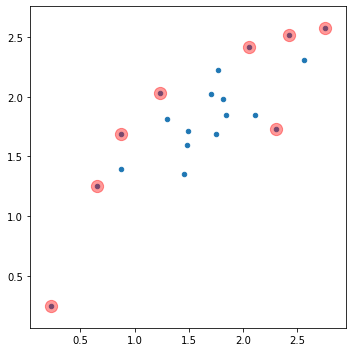

## AVTA

CPU times: user 2.6 ms, sys: 102 µs, total: 2.71 ms
Wall time: 2.63 ms


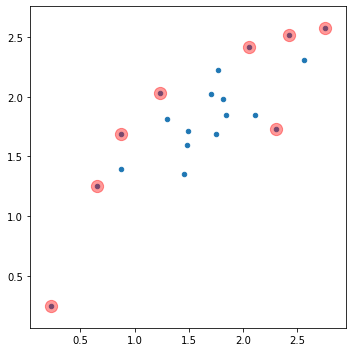

---

# 100 points

## Triangle

CPU times: user 137 ms, sys: 1.55 ms, total: 139 ms
Wall time: 141 ms


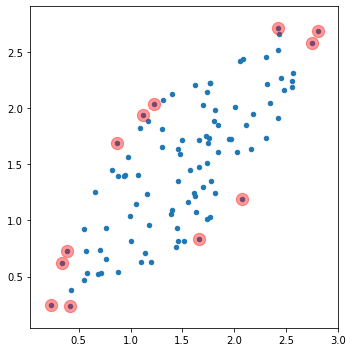

## AVTA

CPU times: user 44 ms, sys: 1.1 ms, total: 45.1 ms
Wall time: 50.8 ms


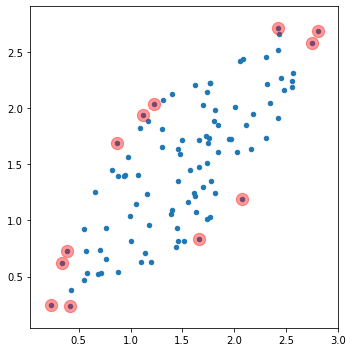

---

# 500 points

## Triangle

CPU times: user 5.95 s, sys: 73.6 ms, total: 6.02 s
Wall time: 6.09 s


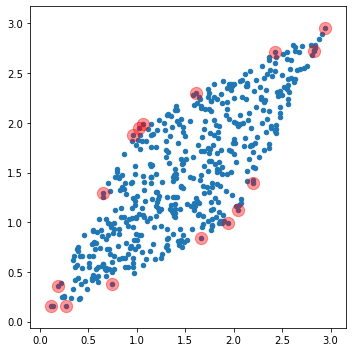

## AVTA

CPU times: user 200 ms, sys: 2.65 ms, total: 202 ms
Wall time: 206 ms


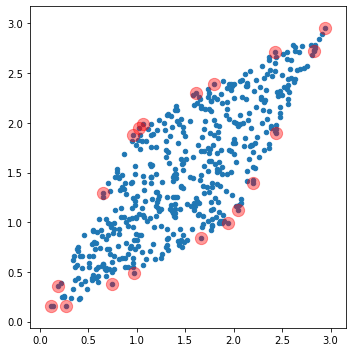

---

# 1000 points

## Triangle

CPU times: user 27.4 s, sys: 301 ms, total: 27.7 s
Wall time: 27.9 s


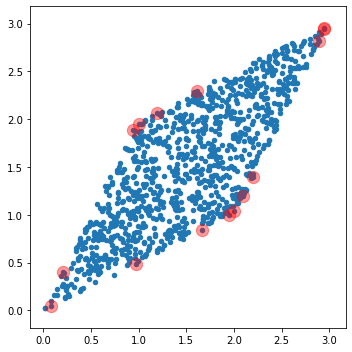

## AVTA

CPU times: user 582 ms, sys: 6.22 ms, total: 588 ms
Wall time: 591 ms


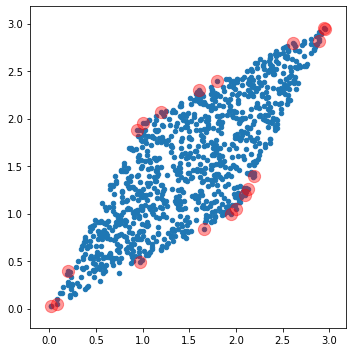

In [42]:
from IPython.display import display, Markdown
md = lambda *a: display(Markdown(*a))

triangle_hull(generate_points(20))  # force jit compilation

for n in (20, 100, 500, 1000):
    md('---')
    md(f'# {n} points')
    for method in ('Triangle', 'AVTA'):
        md(f'## {method}')
        plot_hull(method, n)

# Convex pruning

In [43]:
import itertools

def in_hull(S, p):
    # use Delaunay triangulation:
    # https://stackoverflow.com/questions/16750618/whats-an-efficient-way-to-find-if-a-point-lies-in-the-convex-hull-of-a-point-cl
    hull = scipy.spatial.Delaunay(S)
    # this is lazy and slow; better to do a dot product to check if the point is on the same side of all hyperplanes
    return hull.find_simplex(p) >= 0

def prune_hull(S, return_mask = False):
    # find convex polytope inside the convex hull and prune points inside it:
    # http://mindthenerd.blogspot.com/2012/05/fastest-convex-hull-algorithm-ever.html
    ndim = S.shape[1]
    if S.shape[0] <= (2 ** ndim):
        return S
    translation_matrix = np.array(list(itertools.product([1, -1], repeat=ndim)))
    boundary_points = np.dot(S, translation_matrix.T).argmax(axis=0)
    inner_polygon = S[boundary_points]
    selected = ~in_hull(S[boundary_points], S)
    selected[boundary_points] = True
    return selected if return_mask else S[selected]

Generate 1 million points (uniform), see how long it takes to prune non-hull points:

CPU times: user 45.1 ms, sys: 4.16 ms, total: 49.3 ms
Wall time: 13.6 ms
Points left: 658


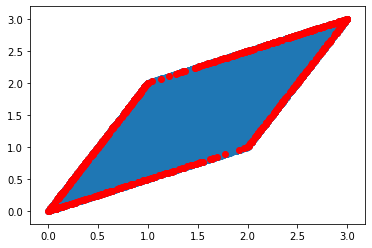

In [44]:
md('Generate 1 million points (uniform), see how long it takes to prune non-hull points:')
S = generate_points(100_000)
S_p = %time prune_hull(S)
plt.scatter(*S.T)
plt.scatter(*prune_hull(S).T, color='r')
print('Points left:', len(S_p))

Generate 1 million points (normal), see how long it takes to prune non-hull points:

CPU times: user 42.8 ms, sys: 5.03 ms, total: 47.8 ms
Wall time: 13.2 ms
Points left: 1672


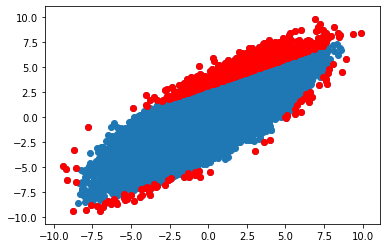

In [45]:
md('Generate 1 million points (normal), see how long it takes to prune non-hull points:')
S = generate_points(100_000, dist='normal')
S_p = %time prune_hull(S)
plt.scatter(*S.T)
plt.scatter(*prune_hull(S).T, color='r')
print('Points left:', len(S_p))

# Delaunay triangulation

In [46]:
# Faster than triangle, slower than AVTA

In [47]:
def delaunay_hull(S):
    out = np.zeros(len(S), bool)
    for i in range(len(S)):
        v = S[i]
        S_v = np.concatenate([S[:i], S[i + 1:]])
        out[i] = not in_hull(S_v, v)
    return out

CPU times: user 8.83 s, sys: 323 ms, total: 9.16 s
Wall time: 9.24 s


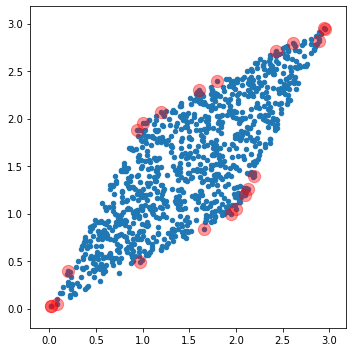

In [48]:
plot_hull('delaunay', 1000)

# AVTA with inner polytope pruning

In [49]:
def avta_hull_with_pruning(S):
    mask = prune_hull(S, return_mask=True)
    out = np.zeros(len(S), bool)
    indices = mask.nonzero()[0]
    S_p = S[mask]
    is_avta = avta_hull(S_p)
    out[indices[is_avta]] = True
    return out

---

## AVTA with inner polytope pruning: uniform, 100,000 points

CPU times: user 14.6 s, sys: 148 ms, total: 14.8 s
Wall time: 14.4 s


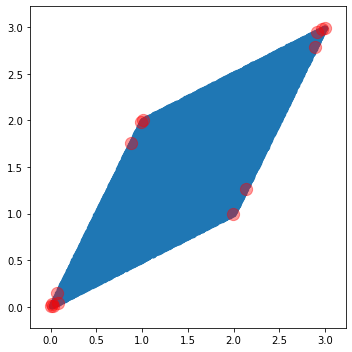

---

## AVTA with inner polytope pruning: normal, 100,000 points

CPU times: user 1 s, sys: 22.2 ms, total: 1.02 s
Wall time: 572 ms


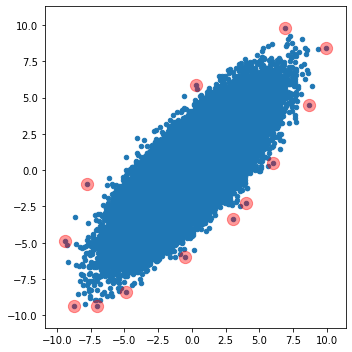

In [50]:
n = 100_000
for dist in ('uniform', 'normal'):
    md('---')
    md(f'## AVTA with inner polytope pruning: {dist}, {n:,d} points')
    plot_hull(avta_hull_with_pruning, n, dist=dist)

# `Quickhull` algorithm

- http://www.qhull.org/
- https://dl.acm.org/doi/10.1145/235815.235821
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html

In [51]:
def qhull(S):
    hull = scipy.spatial.ConvexHull(S)
    out = np.zeros(len(S), bool)
    out[hull.vertices] = True
    return out

---

# Quickhull (1,000 points)

## 1,000 points (uniform)

CPU times: user 669 µs, sys: 528 µs, total: 1.2 ms
Wall time: 2.09 ms


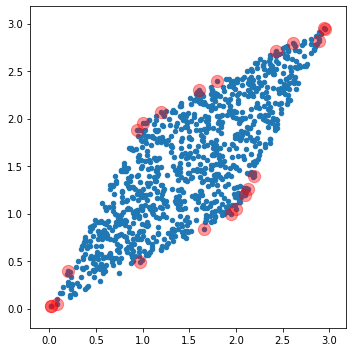

## 1,000 points (normal)

CPU times: user 543 µs, sys: 264 µs, total: 807 µs
Wall time: 819 µs


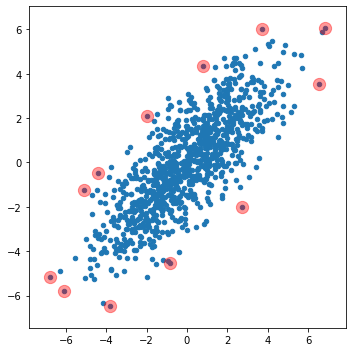

---

# Quickhull (1,000,000 points)

## 1,000,000 points (uniform)

CPU times: user 584 ms, sys: 33.5 ms, total: 618 ms
Wall time: 189 ms


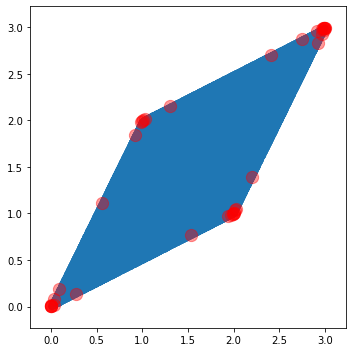

## 1,000,000 points (normal)

CPU times: user 563 ms, sys: 31.1 ms, total: 594 ms
Wall time: 157 ms


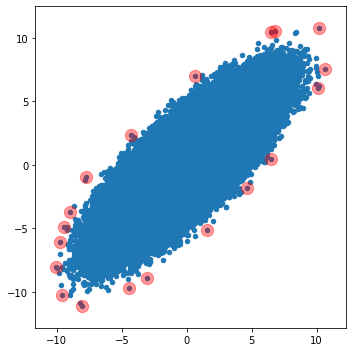

In [52]:
for n in (1000, 1_000_000):
    md('---')
    md(f'# Quickhull ({n:,d} points)')
    for dist in ('uniform', 'normal'):
        md(f'## {n:,d} points ({dist})')
        plot_hull(qhull, n, dist=dist)       

# Benchmark on test 3-D data

In [17]:
import pandas as pd
data = pd.read_csv('./avta_test_001.csv', header=None).values
data.shape

(500, 3)

### Quickhull

In [33]:
%time data[qhull(data)]

CPU times: user 1.14 ms, sys: 1.18 ms, total: 2.32 ms
Wall time: 1.25 ms


array([[0., 0., 1.],
       [2., 0., 0.],
       [0., 2., 0.],
       [2., 2., 0.],
       [0., 0., 0.]])

### AVTA ($\gamma=10^{-3}$)

In [36]:
%time data[avta_hull(data, 1e-3)]

CPU times: user 15.7 s, sys: 148 ms, total: 15.8 s
Wall time: 15.9 s


array([[0., 0., 1.],
       [2., 0., 0.],
       [0., 2., 0.],
       [2., 2., 0.],
       [0., 0., 0.]])

### AVTA ($\gamma=10^{-2}$)

In [37]:
%time data[avta_hull(data, 1e-2)]

CPU times: user 148 ms, sys: 3.57 ms, total: 152 ms
Wall time: 151 ms


array([[0., 0., 1.],
       [2., 0., 0.],
       [0., 2., 0.],
       [2., 2., 0.],
       [0., 0., 0.]])

### Find some embedded convex polytope and prune points inside of it

In [38]:
%time prune_hull(data)

CPU times: user 950 µs, sys: 951 µs, total: 1.9 ms
Wall time: 1.17 ms


array([[0., 0., 1.],
       [2., 0., 0.],
       [0., 2., 0.],
       [2., 2., 0.],
       [0., 0., 0.]])

#### ... in this example, pruning removes *everything* except for the convex hull

### In case there's anything still left after pruning, AVTA is applied on top:

In [32]:
%time data[avta_hull_with_pruning(data)]

CPU times: user 2.67 ms, sys: 1.49 ms, total: 4.15 ms
Wall time: 2.85 ms


array([[0., 0., 1.],
       [2., 0., 0.],
       [0., 2., 0.],
       [2., 2., 0.],
       [0., 0., 0.]])